In [1]:
### Investigation of how the model performing best and being trained on images from NRW annotated by us
### performs on the >30.000 images data set from California

# It investigates 
#1)  how does the best model (xception model with pre-trained weights from imagenet and all layers set to trainable during the 
#    further training process on the NRW data set) perform on the California data set

#2) how it performs on the california and NRW data set if it is further trained on the Cali data set for 5 epochs

#3) how the same model type (xception, pre-trained, all layers trainable) performs on the Cali and NRW dataset if it 
#   is not pre-trained on NRW data, but only on Cali data for 5 epochs

#4) doing the same with the NRW data training for 48 epochs first and then evaluating on NRW and Cali data

#5) then retraining this data set for 5 epochs on the Cali data set and evaluating again on NRW and Cali data

#6) then checking if it is an exception occuring only for the Xception network or if any of the other models pre-trained on 
#   the NRW data set is performing better

In [3]:
### setting the different directories 

# on the server (linux):
# where to find the images:
#home_dir = '/home/rick/Documents/HannahZ'
# folder where to save code and so on
#code_dir = home_dir + '/Code'
# where to save the final models
#model_dir = code_dir + '/Final_models'
# where to save the logs for visualization in TensorBoard
#log_dir = code_dir + '/logs'
# where to save the weights
#new_weight_dir = code_dir + '/new_weights'

# # on my computer (windows):
# # where to find the images:
home_dir = '\\Users\\ThinkPad User\\Google Drive\\DeepSolaris'
# # folder where to save code and so on
code_dir = '\\Users\\ThinkPad User\\Google Drive\\Master_thesis_H_Z_DL&NN\\Results'
# # where to save the final models
model_dir = 'E:\\FinalModels\\'
# # where to save the logs for visualization in TensorBoard
log_dir = code_dir + '\\logs'


import os
os.chdir(home_dir)

In [4]:
import numpy as np

In [5]:
### Loading the images from California (over 30.000 just for training)

os.chdir(home_dir)
train_images = np.load('train_images_Bradbury.npy')
# valid_images = np.load('validation_images_AcMüDüHo.npy')
test_images = np.load('test_images_Bradbury.npy')
train_labels = np.load('train_labels_Bradbury.npy')
# valid_labels = np.load('validation_labels_AcMüDüHo.npy')
test_labels = np.load('test_labels_Bradbury.npy')

print("Size of:")
print("- Training-set:\t\t{}".format(len(train_labels)))
# print("- Validation-set:\t{}".format(len(valid_labels)))
print("- Test-set:\t\t{}".format(len(test_labels)))

Size of:
- Training-set:		31776
- Test-set:		7946


In [6]:
### Loading the images from NRW I used for my thesis

os.chdir(home_dir)
Atrain_images = np.load('training_images_AcMüDüHo.npy')
Avalid_images = np.load('validation_images_AcMüDüHo.npy')
Atest_images = np.load('test_images_AcMüDüHo.npy')
Atrain_labels = np.load('training_labels_AcMüDüHo.npy')
Avalid_labels = np.load('validation_labels_AcMüDüHo.npy')
Atest_labels = np.load('test_labels_AcMüDüHo.npy')

print("Size of:")
print("- Training-set:\t\t{}".format(len(Atrain_labels)))
print("- Validation-set:\t{}".format(len(Avalid_labels)))
print("- Test-set:\t\t{}".format(len(Atest_labels)))

Size of:
- Training-set:		3357
- Validation-set:	374
- Test-set:		934


In [6]:
os.chdir(home_dir)
Htrain_images = np.load('train_images_CBS.npy')
Htest_images = np.load('test_images_CBS.npy')
Htrain_labels = np.load('train_labels_CBS.npy')
Htest_labels = np.load('test_labels_CBS.npy')

print("Size of:")
print("- Training-set:\t\t{}".format(len(Htrain_labels)))
print("- Test-set:\t\t{}".format(len(Htest_labels)))

Size of:
- Training-set:		1848
- Test-set:		464


In [8]:
# import cv2
# import matplotlib.pyplot as plt
# %matplotlib inline
# for i in range(3):
#     print('Cali')
#     ex = train_images[i]
#     #plt.imshow(ex)
#     #plt.show()
#     ex = cv2.resize(ex, (300, 300))
#     cv2.imshow('example', ex)
#     cv2.waitKey(1200)
#     cv2.destroyAllWindows()  
#     print('NRW')
#     #plt.imshow(Atrain_images[i])
#     #plt.show()
#     ex2 = cv2.resize(Atrain_images[i], (300, 300))
#     cv2.imshow('NRW', ex2)
#     cv2.waitKey(2400)
#     cv2.destroyAllWindows()  

In [7]:
### Loading the relevant packages

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from keras.losses import binary_crossentropy
from keras import backend as K

from random import randrange
from random import seed
from random import sample

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from datetime import timedelta
import math
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import keras
from keras.callbacks import Callback

Using TensorFlow backend.


In [8]:
### Helper metrics functions

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall   
def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score
def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

no_of_epochs = 0

In [9]:
os.listdir(model_dir)

['DenseNet121_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet_141_2-e30',
 'DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_3-e04',
 'DenseNet121_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0003_e-96_imagenet_All_2-e08',
 'IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0001_e-48_imagenet_595_3-e29',
 'IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0003_e-96_imagenet_All_3-e63',
 'IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0005_e-48_imagenet_Frozen_4-e16',
 'IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0-e04',
 'IncV3_bs-64_triangular2_sz-315_blr-1e-06_mlr-0.0001_e-96_imagenet_Frozen_4-e08',
 'IncV3_bs-64_triangular2_sz-420_blr-1e-06_mlr-0.0002_e-96_imagenet_229__ensemble__',
 'Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet_Frozen_3-e42',
 'Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0004_e-96_imagenet_All_1-e73',
 'Xception_bs-64_triangular_sz-315_blr-5e-05_mlr-0.0006_e-48_imag

In [91]:
### Loading the model which performed best on the NRW test set, from all the models build before

bestModelName = 'Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0004_e-96_imagenet_All_1-e73'
from keras.models import load_model
os.chdir(model_dir)
boModel = load_model(bestModelName, 
                     custom_objects={'precision': precision, 'recall': recall, 
                                                            'fbeta_score': fbeta_score, 'fmeasure': fmeasure})

In [ ]:
### Evaluating the best-of-model on the data set of Heerlen
print('    Heerlen      ')
print('train_metrics') 
HtrainingRes = boModel.evaluate(Htrain_images, Htrain_labels)
for i, j in zip(metrics,HtrainingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('test_metrics') 
HtestingRes = boModel.evaluate(Htest_images, Htest_labels)
for i, j in zip(metrics,HtestingRes):
    print('{:12} :\t{:.4f}'.format(i,j))

In [28]:
### Evaluating the best-of-model on the Californian data set from BradBury

print('       California           ')
print('train_metrics') 
trainingRes = boModel.evaluate(train_images, train_labels)
metrics = boModel.metrics_names
for i, j in zip(metrics,trainingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')
print('test_metrics') 
testingRes = boModel.evaluate(test_images, test_labels)
for i, j in zip(metrics,testingRes):
    print('{:12} :\t{:.4f}'.format(i,j))

# -> worse than guessing

       California           
train_metrics
31776/31776 [==============================] - 44s 1ms/step
loss         :	1.4672
acc          :	0.7287
precision    :	0.7200
recall       :	0.7496
fmeasure     :	0.7287

test_metrics
7946/7946 [==============================] - 11s 1ms/step
loss         :	1.5187
acc          :	0.7230
precision    :	0.7120
recall       :	0.7501
fmeasure     :	0.7249


In [29]:
### Evaluating it on the data is was already trained and tested on just to check if the loadig worked

print('       NRW           ')
print('train_metrics') 
AtrainingRes = boModel.evaluate(Atrain_images, Atrain_labels)
metrics = boModel.metrics_names
for i, j in zip(metrics,AtrainingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('test_metrics') 
AtestingRes = boModel.evaluate(Atest_images, Atest_labels)
for i, j in zip(metrics,AtestingRes):
    print('{:12} :\t{:.4f}'.format(i,j))

# -> it worked as the model performs as good as before

       NRW           
train_metrics
3357/3357 [==============================] - 5s 1ms/step
loss         :	1.2569
acc          :	0.8108
precision    :	0.7796
recall       :	0.8650
fmeasure     :	0.8155
test_metrics
934/934 [==============================] - 1s 1ms/step
loss         :	1.2356
acc          :	0.8201
precision    :	0.7776
recall       :	0.9085
fmeasure     :	0.8345


In [30]:
### Retraining the best-of-model on the data from the Bradbury data set with the same hyperparameters for 5 epochs

os.chdir(code_dir)
from CyclicLR import CyclicLR
clr = CyclicLR(base_lr = 0.000001, max_lr=0.0004,
                        step_size= 157, mode = 'triangular')
boModel.fit(x = train_images, y = train_labels, epochs = 5, callbacks= [clr], batch_size = 128, verbose = 1)

Epoch 1/5
31776/31776 [==============================] - 26s 831us/step - loss: 0.4566 - acc: 0.8313 - precision: 0.8343 - recall: 0.8295 - fmeasure: 0.8262
Epoch 2/5
31776/31776 [==============================] - 25s 786us/step - loss: 0.3098 - acc: 0.8754 - precision: 0.8575 - recall: 0.9028 - fmeasure: 0.87814s - loss: 0.3098 - acc: 0.8757 - pre
Epoch 3/5
31776/31776 [==============================] - 25s 776us/step - loss: 0.2871 - acc: 0.8841 - precision: 0.8658 - recall: 0.9110 - fmeasure: 0.8867
Epoch 4/5
31776/31776 [==============================] - 25s 783us/step - loss: 0.2700 - acc: 0.8902 - precision: 0.8710 - recall: 0.9180 - fmeasure: 0.89269s - loss: 0.2735 - acc: 0.8866 - preci - ETA: 4s - loss: 0.2710 - acc: 0.8881 - precisi
Epoch 5/5
31776/31776 [==============================] - 25s 788us/step - loss: 0.2577 - acc: 0.8956 - precision: 0.8782 - recall: 0.9205 - fmeasure: 0.8977


In [31]:
### checking the results of the retraining

print('for California:')
print('train_metrics') 
trainingRes = boModel.evaluate(train_images, train_labels)
for i, j in zip(metrics,trainingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')
print('test_metrics') 
testingRes = boModel.evaluate(test_images, test_labels)
for i, j in zip(metrics,testingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')

print('for NRW:')
print('train_metrics') 
AtrainingRes = boModel.evaluate(Atrain_images, Atrain_labels)
for i, j in zip(metrics,AtrainingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')
print('test_metrics') 
AtestingRes = boModel.evaluate(Atest_images, Atest_labels)
for i, j in zip(metrics,AtestingRes):
    print('{:12} :\t{:.4f}'.format(i,j))

for California:
train_metrics
31776/31776 [==============================] - 44s 1ms/step
loss         :	1.2182
acc          :	0.7281
precision    :	0.6485
recall       :	0.9975
fmeasure     :	0.7820

test_metrics
7946/7946 [==============================] - 11s 1ms/step
loss         :	1.2788
acc          :	0.7240
precision    :	0.6457
recall       :	0.9957
fmeasure     :	0.7794

for NRW:
train_metrics
3357/3357 [==============================] - 5s 1ms/step
loss         :	2.0641
acc          :	0.6571
precision    :	0.5929
recall       :	0.9883
fmeasure     :	0.7373

test_metrics
934/934 [==============================] - 1s 1ms/step
loss         :	2.2196
acc          :	0.6488
precision    :	0.5928
recall       :	0.9872
fmeasure     :	0.7384


In [ ]:
### chosing the model that performed best (Xception using transfer learning and having all layers trainable), and training it
### directly on the Bradbury data sets without using the pre-trained weigths learned from the NRW data set

In [32]:
# choose training specifications (None or 'imagenet')
weights = 'imagenet'
from keras.applications import xception

# importing the currently used model
os.chdir(code_dir)
### create the base pre-trained model
# usually takes around 30 seconds
Model_base = xception.Xception(weights = weights, include_top=False)

In [33]:
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras import Model

def compileModel():
    global Final_model
    x = Model_base.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(512, activation='relu')(x)
    preds = Dense(1, activation='sigmoid')(x)
    Final_model = Model(inputs=Model_base.input, outputs=preds)
    for layer in Model_base.layers:   # only train the new layers first
        layer.trainable = True
    Final_model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                            metrics=['accuracy', precision, recall, fmeasure])

In [34]:
print(bestModelName)

Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0004_e-96_imagenet_All_1-e73


In [35]:
###################### first training stage ###################################
weights = 'imagenet'
trainable_layers = 'All'
batch_size = 128
step_size = 157
base_lr = 0.000006
max_lr = 0.00001
epochs = 96
mode = 'triangular'
def train_Model(verbose =1, times = 2, epochs = epochs, base_lr = base_lr, max_lr= max_lr, mode = mode, 
                stepsize = step_size, batch_size = batch_size, use_tensorboard = False, 
                train_images = train_images, train_labels = train_labels):
    start_time = time()   
    global h
    global no_of_epochs
    global name
    date = str(datetime.now().date())
    # logdir in linux:
    logdir = (log_dir + '/' + date + '_' + str(batch_size) + '_' + str(mode) + '_si-' + str(stepsize) + '_base-' 
              + str(base_lr) + '_max-' + str(max_lr) + '_' + str(times))
    name = ('batch size: ' + str(batch_size) + ', mode: ' + str(mode) + ', stepsize: ' 
            + str(stepsize) + ', base-lr: ' + str(base_lr) + ', max-lr ' + str(max_lr) + ', *' + str(times))
    print(' - Model specifics:\t{}'.format(name))
    clr = CyclicLR(base_lr = base_lr, max_lr=max_lr,
                        step_size= stepsize, mode = mode)
    tbCallBack = TensorBoard(log_dir=logdir, histogram_freq=0, 
                         write_graph=False, write_images=False)
    if (use_tensorboard == True):
        Final_model.fit(x = train_images, y = train_labels, epochs = epochs, callbacks= [tbCallBack, clr], 
                            batch_size = batch_size, 
                            verbose = verbose)
    else:
        Final_model.fit(x = train_images, y = train_labels, epochs = epochs, callbacks= [clr], 
                            batch_size = batch_size, 
                            verbose = verbose)
    no_of_epochs = no_of_epochs + epochs
    h = []
    h = clr.history
    end_time = time()
    time_dif = end_time - start_time
    print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))) + ' minutes')
print(weights)
print(trainable_layers)


imagenet
All


In [36]:
### Training only for 5 epochs

In [37]:
Final_model = []
compileModel()
train_Model(verbose =1, times = 1, epochs = 5, base_lr = base_lr, max_lr= max_lr, mode = mode, 
                stepsize = step_size, batch_size = batch_size, use_tensorboard = False)

 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 6e-06, max-lr 1e-05, *1
Epoch 1/5
31776/31776 [==============================] - 103s 3ms/step - loss: 0.5327 - acc: 0.7909 - precision: 0.7171 - recall: 0.9857 - fmeasure: 0.8268
Epoch 2/5
31776/31776 [==============================] - 95s 3ms/step - loss: 0.4089 - acc: 0.9160 - precision: 0.8748 - recall: 0.9730 - fmeasure: 0.9202
Epoch 3/5
31776/31776 [==============================] - 95s 3ms/step - loss: 0.2190 - acc: 0.9450 - precision: 0.9310 - recall: 0.9618 - fmeasure: 0.9453
Epoch 4/5
31776/31776 [==============================] - 95s 3ms/step - loss: 0.1098 - acc: 0.9588 - precision: 0.9538 - recall: 0.9649 - fmeasure: 0.9586
Epoch 5/5
31776/31776 [==============================] - 95s 3ms/step - loss: 0.0762 - acc: 0.9698 - precision: 0.9682 - recall: 0.9716 - fmeasure: 0.9695
Time usage: 0:08:16 minutes


In [ ]:
# already achieve an accuracy of >90% even on the test set
# this makes very little sense to me

In [38]:
### checking the results for California 
print('for California:')
print('train_metrics') 
trainingRes = boModel.evaluate(train_images, train_labels)
for i, j in zip(metrics,trainingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')
print('test_metrics') 
testingRes = boModel.evaluate(test_images, test_labels)
for i, j in zip(metrics,testingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')

#... and NRW: 
print('for NRW:')
print('train_metrics') 
AtrainingRes = boModel.evaluate(Atrain_images, Atrain_labels)
for i, j in zip(metrics,AtrainingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')
print('test_metrics') 
AtestingRes = boModel.evaluate(Atest_images, Atest_labels)
for i, j in zip(metrics,AtestingRes):
    print('{:12} :\t{:.4f}'.format(i,j))

for California:
train_metrics
31776/31776 [==============================] - 45s 1ms/step
loss         :	1.2182
acc          :	0.7281
precision    :	0.6485
recall       :	0.9975
fmeasure     :	0.7820

test_metrics
7946/7946 [==============================] - 11s 1ms/step
loss         :	1.2788
acc          :	0.7240
precision    :	0.6457
recall       :	0.9957
fmeasure     :	0.7794

for NRW:
train_metrics
3357/3357 [==============================] - 5s 1ms/step
loss         :	2.0641
acc          :	0.6571
precision    :	0.5929
recall       :	0.9883
fmeasure     :	0.7373

test_metrics
934/934 [==============================] - 1s 1ms/step
loss         :	2.2196
acc          :	0.6488
precision    :	0.5928
recall       :	0.9872
fmeasure     :	0.7384


In [39]:
# train for 5 more epochs
train_Model(verbose =1, times = 1, epochs = 5, base_lr = base_lr, max_lr= max_lr, mode = mode, 
                stepsize = step_size, batch_size = batch_size, use_tensorboard = False)

 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 6e-06, max-lr 1e-05, *1
Epoch 1/5
31776/31776 [==============================] - 95s 3ms/step - loss: 0.0542 - acc: 0.9808 - precision: 0.9815 - recall: 0.9801 - fmeasure: 0.9805
Epoch 2/5
31776/31776 [==============================] - 95s 3ms/step - loss: 0.0353 - acc: 0.9882 - precision: 0.9899 - recall: 0.9866 - fmeasure: 0.9881
Epoch 3/5
31776/31776 [==============================] - 96s 3ms/step - loss: 0.0226 - acc: 0.9927 - precision: 0.9943 - recall: 0.9910 - fmeasure: 0.9926
Epoch 4/5
31776/31776 [==============================] - 96s 3ms/step - loss: 0.0155 - acc: 0.9955 - precision: 0.9971 - recall: 0.9940 - fmeasure: 0.9955
Epoch 5/5
31776/31776 [==============================] - 96s 3ms/step - loss: 0.0102 - acc: 0.9971 - precision: 0.9982 - recall: 0.9960 - fmeasure: 0.9971
Time usage: 0:07:57 minutes


In [40]:
### checking the results for California 
print('for California:')
print('train_metrics') 
trainingRes = boModel.evaluate(train_images, train_labels)
for i, j in zip(metrics,trainingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')
print('test_metrics') 
testingRes = boModel.evaluate(test_images, test_labels)
for i, j in zip(metrics,testingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')

#... and NRW: 
print('for NRW:')
print('train_metrics') 
AtrainingRes = boModel.evaluate(Atrain_images, Atrain_labels)
for i, j in zip(metrics,AtrainingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('')
print('test_metrics') 
AtestingRes = boModel.evaluate(Atest_images, Atest_labels)
for i, j in zip(metrics,AtestingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
    
# ...and Heerlen
print('    Heerlen      ')
print('train_metrics') 
HtrainingRes = boModel.evaluate(Htrain_images, Htrain_labels)
for i, j in zip(metrics,HtrainingRes):
    print('{:12} :\t{:.4f}'.format(i,j))
print('test_metrics') 
HtestingRes = boModel.evaluate(Htest_images, Htest_labels)
for i, j in zip(metrics,HtestingRes):
    print('{:12} :\t{:.4f}'.format(i,j))

for California:
train_metrics
31776/31776 [==============================] - 45s 1ms/step
loss         :	1.2182
acc          :	0.7281
precision    :	0.6485
recall       :	0.9975
fmeasure     :	0.7820

test_metrics
7946/7946 [==============================] - 11s 1ms/step
loss         :	1.2788
acc          :	0.7240
precision    :	0.6457
recall       :	0.9957
fmeasure     :	0.7794

for NRW:
train_metrics
3357/3357 [==============================] - 5s 1ms/step
loss         :	2.0641
acc          :	0.6571
precision    :	0.5929
recall       :	0.9883
fmeasure     :	0.7373

test_metrics
934/934 [==============================] - 1s 1ms/step
loss         :	2.2196
acc          :	0.6488
precision    :	0.5928
recall       :	0.9872
fmeasure     :	0.7384
    Heerlen      
train_metrics
1848/1848 [==============================] - 3s 2ms/step
loss         :	3.4379
acc          :	0.5038
precision    :	0.5000
recall       :	0.5016
fmeasure     :	0.5007
test_metrics
464/464 [===========================

In [ ]:
### to exclude that something went wrong with loading the model, the xception network is loaded as it is, then trained for 48 
### epochs on the NRW data set and then trained again for 5 epochs on the Bradbury data set

In [ ]:
Final_model = []
compileModel()
train_Model(verbose =1, times = 1, epochs = 5, base_lr = base_lr, max_lr= max_lr, mode = mode, 
                stepsize = step_size, batch_size = batch_size, use_tensorboard = False,
           train_images = Atrain_images, train_labels = Atrain_labels)

In [ ]:
print('    NRW      ')
print('train_metrics') 
trainingAcc = Final_model.evaluate(Atrain_images, Atrain_labels)[1]
print(trainingAcc)
print('test_metrics') 
testingAcc = Final_model.evaluate(Atest_images, Atest_labels)[1]
print(testingAcc)

In [41]:
Final_model.fit(x = train_images, y = train_labels, epochs = 48, callbacks= [clr], 
                            batch_size = batch_size, verbose = 1)

Epoch 1/5
31776/31776 [==============================] - 95s 3ms/step - loss: 0.0071 - acc: 0.9983 - precision: 0.9988 - recall: 0.9980 - fmeasure: 0.9984
Epoch 2/5
31776/31776 [==============================] - 96s 3ms/step - loss: 0.0054 - acc: 0.9984 - precision: 0.9987 - recall: 0.9981 - fmeasure: 0.9984
Epoch 3/5
31776/31776 [==============================] - 96s 3ms/step - loss: 0.0048 - acc: 0.9990 - precision: 0.9992 - recall: 0.9989 - fmeasure: 0.9990
Epoch 4/5
31776/31776 [==============================] - 96s 3ms/step - loss: 0.0107 - acc: 0.9980 - precision: 0.9982 - recall: 0.9976 - fmeasure: 0.9979
Epoch 5/5
31776/31776 [==============================] - 96s 3ms/step - loss: 0.0055 - acc: 0.9985 - precision: 0.9986 - recall: 0.9983 - fmeasure: 0.9984


In [42]:
### checking the results for California 
print('train_metrics') 
trainingAcc = Final_model.evaluate(train_images, train_labels)[1]
print(trainingAcc)
print('test_metrics') 
testingAcc = Final_model.evaluate(test_images, test_labels)[1]
print(testingAcc)

#... and NRW: 
print('    NRW      ')
print('train_metrics') 
trainingAcc = Final_model.evaluate(Atrain_images, Atrain_labels)[1]
print(trainingAcc)
print('test_metrics') 
testingAcc = Final_model.evaluate(Atest_images, Atest_labels)[1]
print(testingAcc)

train_metrics
31776/31776 [==============================] - 45s 1ms/step
[0.0019756040841845935, 0.9994335347432024, 0.99977174656388745, 0.99902841649867014, 0.99937881563845476]
test_metrics
7946/7946 [==============================] - 11s 1ms/step
[0.16572030939293919, 0.97596274855273091, 0.98318925445157213, 0.96792361780104696, 0.97460047772030911]


In [ ]:
### then retraining it on the Cali-data-set for 5 epochs

In [15]:
from keras.models import Model
compileModel()
train_Model(verbose =1, times = 1, epochs = 5, base_lr = base_lr, max_lr= max_lr, mode = mode, 
                stepsize = step_size, batch_size = batch_size, use_tensorboard = False)

 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 6e-06, max-lr 0.0004, *1
Epoch 1/96
31776/31776 [==============================] - 103s 3ms/step - loss: 0.2106 - acc: 0.9262 - precision: 0.9106 - recall: 0.9575 - fmeasure: 0.9305
Epoch 2/96
31776/31776 [==============================] - 95s 3ms/step - loss: 0.0481 - acc: 0.9826 - precision: 0.9815 - recall: 0.9837 - fmeasure: 0.9824
Epoch 3/96
31776/31776 [==============================] - 95s 3ms/step - loss: 0.0246 - acc: 0.9920 - precision: 0.9915 - recall: 0.9926 - fmeasure: 0.9920
Epoch 4/96
31776/31776 [==============================] - 95s 3ms/step - loss: 0.0182 - acc: 0.9949 - precision: 0.9955 - recall: 0.9944 - fmeasure: 0.9949
Epoch 5/96
31776/31776 [==============================] - 94s 3ms/step - loss: 0.0159 - acc: 0.9957 - precision: 0.9953 - recall: 0.9961 - fmeasure: 0.9957
Epoch 6/96
31776/31776 [==============================] - 94s 3ms/step - loss: 0.0100 - acc: 0.9975 - precision: 0.

In [19]:
### checking the results for California 
print('train_metrics') 
trainingAcc = Final_model.evaluate(train_images, train_labels)[1]
print(trainingAcc)
print('test_metrics') 
testingAcc = Final_model.evaluate(test_images, test_labels)[1]
print(testingAcc)

#... and NRW: 
print('    NRW      ')
print('train_metrics') 
trainingAcc = Final_model.evaluate(Atrain_images, Atrain_labels)[1]
print(trainingAcc)
print('test_metrics') 
testingAcc = Final_model.evaluate(Atest_images, Atest_labels)[1]
print(testingAcc)

# ...and Heerlen
print('    Heerlen      ')
print('train_metrics') 
trainingAcc = boModel.evaluate(Htrain_images, Htrain_labels)[1]
print(trainingAcc)
print('test_metrics') 
testingAcc = boModel.evaluate(Htest_images, Htest_labels)[1]
print(testingAcc)

train_metrics
31776/31776 [==============================] - 42s 1ms/step
0.6074
test_metrics
7946/7946 [==============================] - 11s 1ms/step
0.6063


In [ ]:
### checking if it is an exception occuring only for the Xception network or if any of the other models pre-trained on the
### NRW data set is performing better:

In [51]:
os.chdir(model_dir)
nameList = os.listdir(model_dir)
def evalModels():
    start_time = time()
    global test_acc_list; global train_acc_list; global test_loss_list
    global train_loss_list; global test_prec_list
    global train_prec_list; global test_rec_list; global train_rec_list
    global model_details
    model_details = []; test_acc_list = []; train_acc_list = []; test_loss_list = []
    train_loss_list = []; test_prec_list = []
    train_prec_list = []; test_rec_list = []; train_rec_list = []
    for name in nameList:
        print(name)
        Final_model = load_model(name, custom_objects={'precision': precision, 'recall': recall, 
                                 'fbeta_score': fbeta_score, 'fmeasure': fmeasure})
        train_metrics = Final_model.evaluate(train_images, train_labels)
        test_metrics = Final_model.evaluate(test_images, test_labels)
        train_acc = train_metrics[1]; test_acc = test_metrics[1]
        train_loss = train_metrics[0]; test_loss = test_metrics[0]
        train_prec = train_metrics[2];  test_prec = test_metrics[2]
        train_rec = train_metrics[3]; test_rec = test_metrics[3]         
        test_acc_list.append(test_acc); train_acc_list.append(train_acc)
        test_loss_list.append(test_loss); train_loss_list.append(train_loss)
        test_prec_list.append(test_prec); train_prec_list.append(train_prec)
        test_rec_list.append(test_rec); train_rec_list.append(train_rec)
        model_details.append(name)
    end_time = time()
    time_dif = end_time - start_time
    print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))) + ' minutes')
evalModels()

IncV3_bs-64_triangular2_sz-420_blr-1e-06_mlr-0.0002_e-96_imagenet_229__ensemble__
7946/7946 [==============================] - 8s 1ms/step
IncV3_bs-64_triangular2_sz-315_blr-1e-06_mlr-0.0001_e-96_imagenet_Frozen_4-e08
7946/7946 [==============================] - 8s 1ms/step
IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0005_e-48_imagenet_Frozen_4-e16
7946/7946 [==============================] - 17s 2ms/step
Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet_Frozen_3-e42
7946/7946 [==============================] - 13s 2ms/step
IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0003_e-96_imagenet_All_3-e63
7946/7946 [==============================] - 18s 2ms/step
Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0004_e-96_imagenet_All_1-e73
7946/7946 [==============================] - 15s 2ms/step
DenseNet121_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet_141_2-e30
7946/7946 [==============================] - 14s 2ms/step
DenseNet121_bs-64_triangula

In [53]:
testData = np.array((test_acc_list, test_loss_list, test_prec_list, test_rec_list, train_acc_list))
testColumns = ['test acc', 'test loss', 'test prec', 'test rec', 'train acc']
shortRes = pd.DataFrame(data = testData, columns = model_details, index = testColumns)
ShortAllModelOvw = pd.DataFrame(data = shortRes.transpose(), columns = testColumns, index = model_details)
ShortAllModelOvw.sort_values(by=['test acc'], ascending = False)

,test acc,test loss,test prec,test rec
DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_3-e04,0.639819,3.216919,0.614226,0.747921
DenseNet121_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0003_e-96_imagenet_All_2-e08,0.621319,4.400646,0.570508,0.980548
DenseNet121_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet_141_2-e30,0.607350,4.450650,0.562837,0.964576
IncV3_bs-64_triangular2_sz-315_blr-1e-06_mlr-0.0001_e-96_imagenet_Frozen_4-e08,0.602316,5.770830,0.589164,0.682436
IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0-e04,0.500126,7.968705,0.500081,1.000000
IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0005_e-48_imagenet_Frozen_4-e16,0.500000,8.059048,0.000000,0.000000
IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0003_e-96_imagenet_All_3-e63,0.500000,8.059048,0.000000,0.000000
IncResNetV2_bs-64_triangular_sz-315_blr-1e-06_mlr-0.0001_e-48_imagenet_595_3-e29,0.500000,8.059048,0.000000,0.000000
IncV3_bs-64_triangular2_sz-420_blr-1e-06_mlr-0.0002_e-96_imagenet_229__ensemble__,0.497861,4.983025,0.498976,0.988217
Xception_bs-128_triangular_sz-157_blr-1e-06_mlr-0.0002_e-48_imagenet_Frozen_3-e42,0.495344,7.825194,0.498004,0.979937


In [48]:
# evaluation with bootstrapping
seed(1)
ratio = 0.1    # proportion of data that is used for subsample

def subsample(dataset, labels = test_labels, ratio= ratio):
    pred_sample = list()
    label_sample = list()
    n_sample = round(len(dataset) * ratio)
    index = sample(range(len(dataset)), n_sample)
    pred_sample = dataset[index]
    label_sample = labels[index]           
    return pred_sample, label_sample

def bootstrap(dataset, iterations = 20, ratio = ratio, labels = test_labels):    
    for i in range (iterations):
        b_pred, b_labels = subsample(dataset, labels, ratio)
        lo = cross_entropy(b_pred, b_labels)
        b_pred_rounded = b_pred.round()
        acc = accuracy_score(b_labels, b_pred_rounded)
        pre = precision_score(b_labels, b_pred_rounded)
        rec = recall_score(b_labels, b_pred_rounded)
        loss.append(lo)
        accuracy.append(acc)
        precisions.append(pre)
        recalls.append(rec)
        if (i%1000 == 0): 
            print('Iteration_' + str(i))
            
def cross_entropy(predictions, targets, epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(np.sum(targets*np.log(predictions+1e-9)))/N
    return ce

In [ ]:
boPreds = boModel.predict(test_images, batch_size = 64).squeeze(axis = 1)

In [28]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

Iteration_0
Iteration_1000
Iteration_2000
Iteration_3000
Iteration_4000
Iteration_5000
Iteration_6000
Iteration_7000
Iteration_8000
Iteration_9000


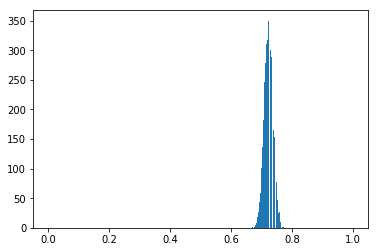

In [47]:
loss = []
accuracy = []
precisions = []
recalls = []
f_measures = []

### for the best of Model
%matplotlib inline
bootstrap(iterations = 10000, dataset = boPreds)
plt.hist(accuracy, bins = 700, range = [0,1])
plt.show
acc_boModel = accuracy
loss_boModel = loss
pre_boModel = precisions
rec_boModel = recall

In [44]:
#plt.hist(precisions, bins = 100, range = [0,1], color = 'forestgreen')
#plt.hist(recalls, bins = 100, range = [0,1], color = 'indianred')
#plt.hist(loss, bins = 100, color = 'skyblue')
#plt.show

In [93]:
### loading the best model from the mixed training
ModelName = 'FINAL'
os.chdir(model_dir)
mixedModel = load_model(ModelName, 
                     custom_objects={'precision': precision, 'recall': recall, 
                                                            'fbeta_score': fbeta_score, 'fmeasure': fmeasure})
mixedPreds = mixedModel.predict(test_images, batch_size = 64).squeeze(axis = 1)

Iteration_0
Iteration_1000
Iteration_2000
Iteration_3000
Iteration_4000
Iteration_5000
Iteration_6000
Iteration_7000
Iteration_8000
Iteration_9000


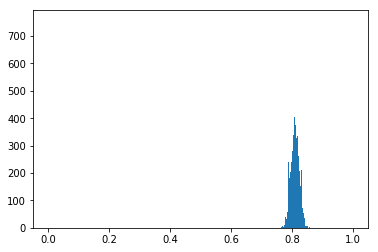

In [50]:
### for the mixed Model
loss = []
accuracy = []
precisions = []
recalls = []

bootstrap(iterations = 10000, dataset = mixedPreds)
plt.hist(accuracy, bins = 700, range = [0,1])
#plt.hist(precisions, bins = 100, range = [0,1])
#plt.hist(recalls, bins = 100, range = [0,1])
#plt.hist(loss, bins = 100)

acc_mixedModel = accuracy
loss_mixedModel = loss
pre_mixedModel = precisions
rec_mixedModel = recall

<function matplotlib.pyplot.show>

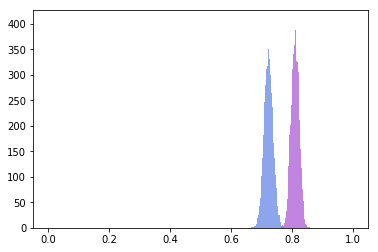

In [139]:
plt.hist(acc_boModel, bins = 800, range = [0,1], color = 'darkorchid', alpha = 0.6)
plt.hist(acc_mixedModel, bins = 800, range = [0,1], color = 'royalblue', alpha = 0.6)
plt.show

In [67]:
# 0-Hypothesis:  both accuracies are the same
# Alternative-H: both accuracies are different

import numpy as np
from scipy import stats

N = 10000
a = np.array(acc_mixedModel)
b = np.array(acc_boModel)

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = a.var(ddof=1)
var_b = b.var(ddof=1)
print(round(var_a, 6)*100)
print(round(var_b, 6)*100)
#std deviation
s = np.sqrt((var_a + var_b)/2)
round(s, 4)

0.0224
0.0171


0.0141

In [74]:
## Calculate the t-statistics
t = (a.mean() - b.mean())/(s*np.sqrt(2/N))
## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)
print("t = " + str(t))
print("p = " + str(2*p))
#Note that we multiply the p value by 2 because its a twp tail t-test
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value 
# of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different 
# and statistically significant.

t = -441.372222632
p = nan


In [60]:
## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(acc_mixedModel ,acc_boModel)
print("t = " + str(t2))
print("p = " + str(2*p2))

t = -441.372222632
p = 0.0


In [98]:
### Now for the NRW data

### for the best of Model
boPreds = boModel.predict(Atest_images, batch_size = 64).squeeze(axis = 1)
loss = []; accuracy = []; precisions = []; recalls = []; f_measures = []

bootstrap(iterations = 10000, dataset = boPreds, labels = Atest_labels)
NRW_acc_boModel = accuracy
NRW_loss_boModel = loss
NRW_pre_boModel = precisions
NRW_rec_boModel = recall

Iteration_0
Iteration_1000
Iteration_2000
Iteration_3000
Iteration_4000
Iteration_5000
Iteration_6000
Iteration_7000
Iteration_8000
Iteration_9000


In [99]:
NRW_acc_boModel[:10]

[0.87096774193548387,
 0.79569892473118276,
 0.81720430107526887,
 0.76344086021505375,
 0.79569892473118276,
 0.83870967741935487,
 0.90322580645161288,
 0.84946236559139787,
 0.76344086021505375,
 0.82795698924731187]

In [104]:
len(NRW_acc_mixedModel)

10000

In [101]:
### for the mixed Model
mixedPreds = mixedModel.predict(Atest_images, batch_size = 64).squeeze(axis = 1)
loss = []; accuracy = []; precisions = []; recalls = []; f_measures = []

bootstrap(iterations = 10000, dataset = mixedPreds, labels = Atest_labels)
NRW_acc_mixedModel = accuracy
NRW_loss_mixedModel = loss
NRW_pre_mixedModel = precisions
NRW_rec_mixedModel = recall

Iteration_0
Iteration_1000
Iteration_2000
Iteration_3000
Iteration_4000
Iteration_5000
Iteration_6000
Iteration_7000
Iteration_8000
Iteration_9000


<function matplotlib.pyplot.show>

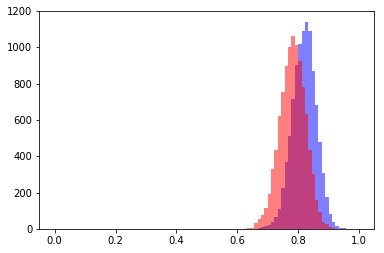

In [120]:
plt.hist(NRW_acc_boModel, bins = 90, range = [0,1], color = 'b', alpha =0.5)
plt.hist(NRW_acc_mixedModel, bins = 90, range = [0,1], color = 'r', alpha =0.5)
plt.show

In [115]:
# 0-Hypothesis:  both accuracies are the same
# Alternative-H: both accuracies are different

import numpy as np
from scipy import stats

N = 10000
NRW_a = np.array(NRW_acc_mixedModel)
NRW_b = np.array(NRW_acc_boModel)

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_aNRW = NRW_a.var(ddof=1)
var_bNRW = NRW_b.var(ddof=1)
print('variance mixedModel: \t{}'.format(round(var_aNRW, 6)*100))
print('variance boModel: \t{}'.format(round(var_bNRW, 6)*100))
#std deviation
sNRW = np.sqrt((var_aNRW + var_bNRW)/2)
print('standard deviation: \t{} '.format(round(s, 4)))

variance mixedModel: 	0.1652
variance boModel: 	0.1407
standard deviation: 	0.0141 


In [123]:
## Calculate the t-statistics
tNRW = (NRW_b.mean() - NRW_a.mean())/(sNRW*np.sqrt(2/N))
## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
pNRW = 1 - stats.t.cdf(tNRW,df=df)
print("t = " + str(tNRW))
print("p = " + str(2*pNRW))
#Note that we multiply the p value by 2 because its a twp tail t-test
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value 
# of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different 
# and statistically significant.

t = 67.1007731575
p = 0.0


In [118]:
## Cross Checking with the internal scipy function
NRWt2, NRWp2 = stats.ttest_ind(NRW_acc_mixedModel ,NRW_acc_boModel)
print("t = " + str(NRWt2))
print("p = " + str(2*NRWp2))

t = -67.1007731575
p = 0.0


In [124]:
############################################################################################
# compare to second-best model                                                             #
############################################################################################
os.chdir(model_dir)
sbModel = load_model('Xception_bs-64_triangular_sz-315_blr-5e-05_mlr-0.0006_e-48_imagenet_86_3-e19', 
                     custom_objects={'precision': precision, 'recall': recall, 'fbeta_score': fbeta_score, 'fmeasure': fmeasure})

In [125]:
### for the best of Model
sbPreds = sbModel.predict(Atest_images, batch_size = 64).squeeze(axis = 1)
loss = []; accuracy = []; precisions = []; recalls = []; f_measures = []

bootstrap(iterations = 10000, dataset = sbPreds, labels = Atest_labels)
NRW_acc_sbModel = accuracy
NRW_loss_sbModel = loss
NRW_pre_sbModel = precisions
NRW_rec_sbModel = recall

Iteration_0
Iteration_1000
Iteration_2000
Iteration_3000
Iteration_4000
Iteration_5000
Iteration_6000
Iteration_7000
Iteration_8000
Iteration_9000


In [126]:
NRW_acc_sbModel[:10]

[0.80645161290322576,
 0.76344086021505375,
 0.83870967741935487,
 0.86021505376344087,
 0.76344086021505375,
 0.75268817204301075,
 0.86021505376344087,
 0.84946236559139787,
 0.91397849462365588,
 0.88172043010752688]

<function matplotlib.pyplot.show>

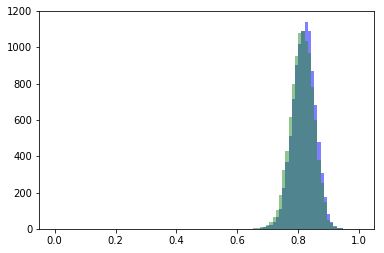

In [130]:
plt.hist(NRW_acc_boModel, bins = 95, range = [0,1], color = 'b', alpha =0.5)
plt.hist(NRW_acc_sbModel, bins = 95, range = [0,1], color = 'forestgreen', alpha =0.5)
plt.show

In [131]:
# 0-Hypothesis:  both accuracies are the same
# Alternative-H: both accuracies are different

N = 10000
aSB = np.array(NRW_acc_sbModel)
bSB = np.array(NRW_acc_boModel)

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_aSB = aSB.var(ddof=1)
var_bSB = bSB.var(ddof=1)
print('variance mixedModel: \t{}'.format(round(var_aSB, 6)*100))
print('variance boModel: \t{}'.format(round(var_bSB, 6)*100))
#std deviation
sSB = np.sqrt((var_aSB + var_bSB)/2)
print('standard deviation: \t{} '.format(round(sSB, 4)))

variance mixedModel: 	0.1508
variance boModel: 	0.1407
standard deviation: 	0.0382 


In [138]:
print(bSB.mean())
print(aSB.mean())

0.820524731183
0.814407526882


In [132]:
## Calculate the t-statistics
tSB = (bSB.mean() - aSB.mean())/(sSB*np.sqrt(2/N))
## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
pSB = 1 - stats.t.cdf(tSB,df=df)
print("t = " + str(tSB))
print("p = " + str(2*pSB))
#Note that we multiply the p value by 2 because its a twp tail t-test
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value 
# of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different 
# and statistically significant.

t = 11.3291156128
p = 0.0


In [135]:
## Cross Checking with the internal scipy function
t2SB, p2SB = stats.ttest_ind(NRW_acc_sbModel ,NRW_acc_boModel)
print("t = " + str(t2SB))
print("p = " + str(2*p2SB))

t = -11.3291156128
p = 2.31896449395e-29
